<a href="https://colab.research.google.com/github/ysurs/nn_with_karpathy/blob/main/batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('/content/drive/MyDrive/building_makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*(5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g)*0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g)* 0.01
b2 = torch.randn(vocab_size,                      generator=g)*0.0

bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [6]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  #print(Yb)
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1  # the b1 will get subtracted out because of the batchnorm layer

  # batchnorm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:2d}/{max_steps:2d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #break

 0/200000: 3.3239
10000/200000: 2.0322
20000/200000: 2.5675
30000/200000: 2.0125
40000/200000: 2.2446
50000/200000: 1.8897
60000/200000: 2.0785
70000/200000: 2.3681
80000/200000: 2.2918
90000/200000: 2.0238
100000/200000: 2.3673
110000/200000: 2.3132
120000/200000: 1.6414
130000/200000: 1.9311
140000/200000: 2.2231
150000/200000: 2.0027
160000/200000: 2.0997
170000/200000: 2.4949
180000/200000: 2.0199
190000/200000: 2.1707


### As we can see, the loss on initialisation is very high and subsequent losses are no where near that value. This shouldn't be the case ideally. On initialisation, every character should have equally likely chance of getting picked up but this high loss value indicates that some characters are more probable of getting picked up than others.

### Ideally the probabilities will be equally likely and equal to 1/27

In [26]:
## The ideal loss on initialisation should be 

(-torch.tensor(1/27).log())

tensor(3.2958)

In [56]:
# A four dimensional example. Assuming the target label is 2
logits=torch.tensor([0.0,0.0,0.0,0.0,0.0])+2
probs=torch.softmax(logits,dim=0)
loss=-probs[2].log()
probs,loss

(tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]), tensor(1.6094))

### If we change numbers from 0, we will get more loss and if we keep every number close to 0, we will get less loss

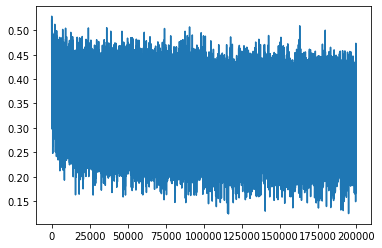

In [19]:
plt.plot(lossi)

In [47]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [49]:
bnstd

tensor([[2.3929, 2.1364, 2.2663, 1.9944, 2.1860, 2.3736, 2.2576, 2.3451, 2.3578,
         2.1045, 2.4973, 2.2571, 2.1519, 2.2017, 2.0989, 2.7105, 2.4423, 1.8902,
         2.2073, 2.5144, 2.3232, 2.3402, 2.1268, 2.0214, 2.0374, 1.8407, 2.1634,
         2.6021, 2.2403, 2.3329, 1.7083, 1.9046, 2.0957, 1.8207, 2.0848, 1.9323,
         2.4885, 2.1671, 2.1170, 1.8611, 2.0108, 2.0911, 2.4064, 1.9754, 1.9694,
         2.4172, 2.1965, 2.5617, 2.1547, 2.4972, 2.0511, 1.8491, 2.0182, 1.7755,
         2.3971, 2.2095, 1.7725, 2.2930, 2.5639, 1.7747, 2.1165, 1.9382, 2.0266,
         2.2968, 2.1514, 2.3390, 2.1540, 2.4904, 2.0355, 2.1785, 2.0923, 1.9757,
         1.9920, 2.2562, 1.9101, 1.8626, 2.5723, 2.2043, 1.6819, 2.2513, 2.0126,
         1.8353, 2.0170, 2.2116, 2.5047, 2.3529, 2.1391, 2.3848, 2.5823, 2.6848,
         2.0914, 1.9556, 2.1100, 1.9680, 1.8658, 2.2201, 2.1905, 2.0695, 1.8927,
         2.3433, 2.0515, 2.1435, 2.2730, 2.0000, 1.9994, 2.2907, 1.8655, 2.2061,
         1.9252, 2.1527, 2.3

In [50]:
bnstd_running

tensor([[2.3689, 2.0998, 2.2499, 1.9599, 2.1515, 2.3429, 2.2431, 2.3104, 2.3309,
         2.0823, 2.4680, 2.2253, 2.1192, 2.1805, 2.0655, 2.6865, 2.4191, 1.8718,
         2.1882, 2.4989, 2.2903, 2.3143, 2.1068, 1.9938, 2.0172, 1.8189, 2.1352,
         2.5721, 2.2250, 2.3027, 1.6857, 1.8987, 2.0912, 1.8024, 2.0771, 1.9073,
         2.4759, 2.1356, 2.0873, 1.8440, 1.9877, 2.0603, 2.3704, 1.9412, 1.9464,
         2.4033, 2.1706, 2.5046, 2.1319, 2.4826, 2.0177, 1.8196, 1.9937, 1.7548,
         2.3758, 2.1857, 1.7500, 2.2775, 2.5494, 1.7520, 2.0970, 1.9272, 2.0154,
         2.2870, 2.1270, 2.3166, 2.1311, 2.4586, 2.0074, 2.1553, 2.0607, 1.9617,
         1.9790, 2.2357, 1.8885, 1.8480, 2.5581, 2.1731, 1.6619, 2.2316, 1.9924,
         1.8106, 1.9824, 2.1808, 2.4859, 2.3152, 2.1121, 2.3617, 2.5755, 2.6760,
         2.0648, 1.9299, 2.1034, 1.9445, 1.8592, 2.1894, 2.1640, 2.0496, 1.8632,
         2.3143, 2.0495, 2.1165, 2.2337, 1.9762, 1.9748, 2.2615, 1.8477, 2.1645,
         1.9084, 2.1207, 2.3

In [51]:
@torch.no_grad() # this decorator disables gradient tracking for efficiency reasons
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact=embcat @ W1 + b1 
  hpreact=bngain*(hpreact-bnmean_running)/(bnstd_running)+bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


loss log
original:
train 2.1245384216308594 val 2.1750576496124268

fix softmax confidently wrong:
train 2.07 val 2.13 (we achieved this by fixing our initialisation loss which we achieved by setting b2 to 0 and reducing W2 values) We did this because, at initialisation, we were getting a very high loss value. Getting high loss is not possible because during initialisation, every character is equally probable and the neural network does favour any particular character.

fix tanh layer too saturated at init: train 2.0355966091156006 val 2.1026785373687744 :We scaled down value of hpreact. This was done because h which we obtain after passing preact to tanh was producing a lot of -1 and 1 values. This can kill gradients.

using kaiming init formula for initialisation: we get train 2.0376641750335693
val 2.106989622116089. Motivation is that we want to have similar gaussian distribution throughout the network and it should happen that after some operations, distribution is changing


using batchnorm: train 2.0668270587921143
val 2.104844808578491


In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1)@W1+b1) # concatenate the vectors
      logits=h@W2+b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amille.
khy.
myli.
taty.
skanden.
jazonen.
amerynchireei.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wanthoniearyn.
kai.
everusabee.
demiia.


***

In [7]:
# SUMMARY + PYTORCHIFYING -----------
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zero(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    #print(self.out)
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [8]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3256


Text(0.5, 1.0, 'activation distribution')

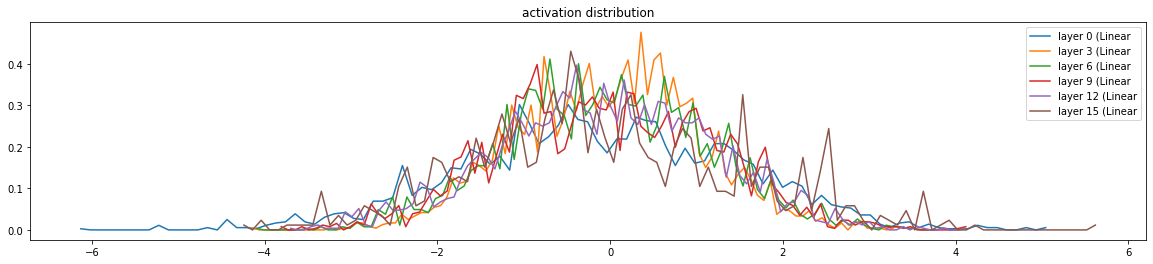

In [9]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out
    #print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.62, saturated: 3.81%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 3.22%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.62%
layer 11 (      Tanh): mean -0.01, std 0.65, saturated: 2.31%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 2.06%


Text(0.5, 1.0, 'activation distribution')

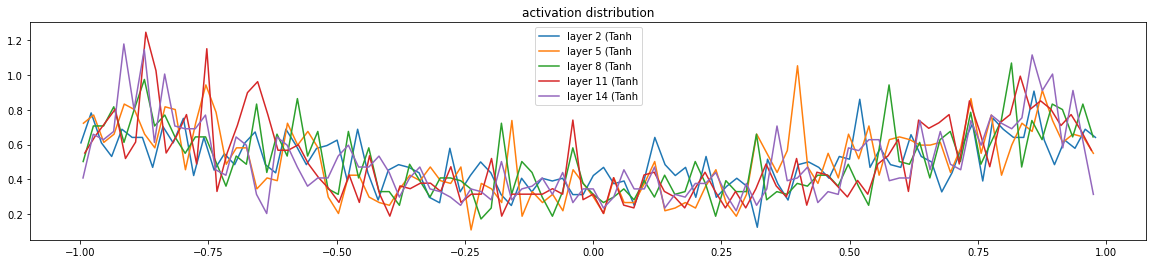

In [10]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.499681e-03
layer 5 (      Tanh): mean +0.000000, std 2.954182e-03
layer 8 (      Tanh): mean +0.000000, std 2.666419e-03
layer 11 (      Tanh): mean +0.000000, std 2.511479e-03
layer 14 (      Tanh): mean -0.000000, std 2.424411e-03


Text(0.5, 1.0, 'gradient distribution')

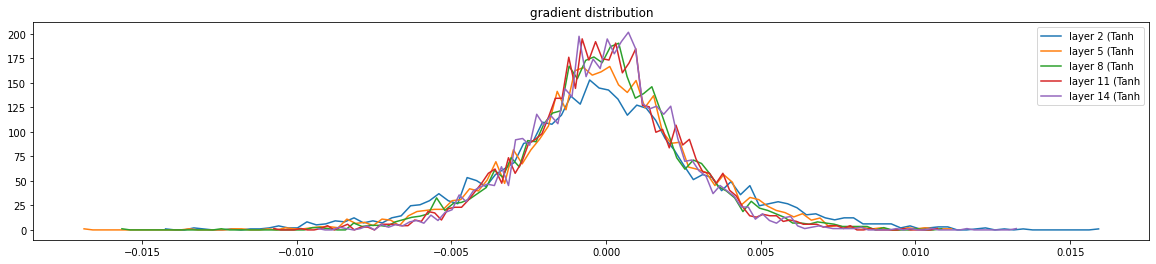

In [11]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.098002e-02 | grad:data ratio 1.096853e-02
weight  (30, 100) | mean +0.000013 | std 7.666034e-03 | grad:data ratio 2.467995e-02
weight (100, 100) | mean -0.000053 | std 6.287718e-03 | grad:data ratio 3.792096e-02
weight (100, 100) | mean +0.000044 | std 5.293272e-03 | grad:data ratio 3.191568e-02
weight (100, 100) | mean +0.000027 | std 4.675829e-03 | grad:data ratio 2.794195e-02
weight (100, 100) | mean +0.000024 | std 4.174258e-03 | grad:data ratio 2.477346e-02
weight  (100, 27) | mean -0.000014 | std 7.510025e-03 | grad:data ratio 4.502932e-02


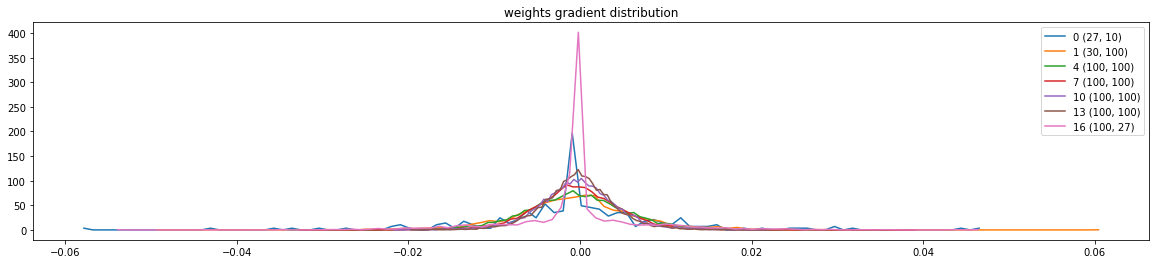

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

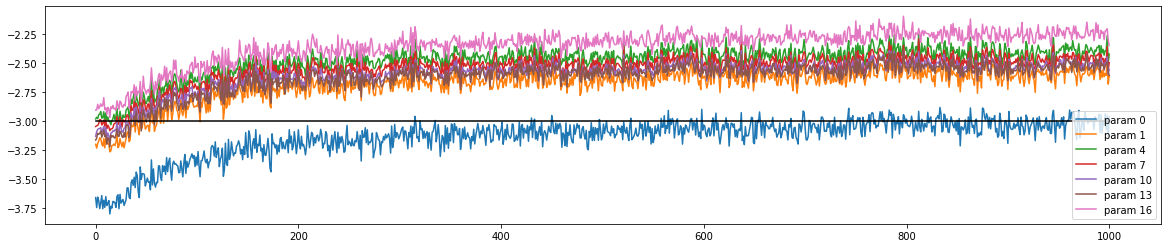

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4170334339141846
val 2.4167935848236084


In [15]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carpahxqa.
jileif.
jmrix.
thty.
sacassa.
jazhnen.
dpn.
rrc.
kaqei.
nelmarahcerihv.
kalein.
dhan.
jori.
qeinn.
salin.
alia.
bqiorathogiearyxix.
kaeuliura.
med.
ecoia.
